## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2019-04-24 19:04:43--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2019-04-24 19:04:44--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uced8d6cef180dcf2ecf6ac8db79.dl.dropboxusercontent.com/cd/0/inline/Afrf6q1Y0vvbi-fbmFOGtOYDNADkeKE2pi_NbfR-vL4GYt774fxfgyY2tBPCM7GT3_8XTD6WF0lfKUep-FLyUsHu2iwNGAwfWR4iCFSSvny_Zg/file# [following]
--2019-04-24 19:04:44--  https://uced8d6cef180dcf2ecf6ac8db79.dl.dropboxusercontent.com/cd/0/inline/Afrf6q1Y0vvbi-fbmFOGtOYDNADkeKE2pi_NbfR-vL4GYt774fxfgyY2tBPCM7GT3_8XTD6WF0lfKUep-FLyUsHu2iwNGAwfWR4iCFSSvny_Zg/file
Resolving uced8d6cef180dcf

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

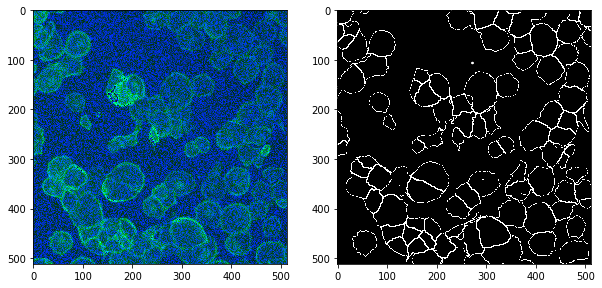

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [0]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms 
import random
import torch.optim as optim

In [0]:
''' inspired by https://pytorch.org/tutorials/beginner/data_loading_tutorial.html'''

class Dataset(Dataset):
    def __init__(self, root_dir, label_dir, transform=None):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.transform = transform
        self.items = sorted(next(os.walk(root_dir))[2])
        self.labels = sorted(next(os.walk(label_dir))[2])

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,self.items[idx])
        img_name_labels = os.path.join(self.label_dir, self.labels[idx])
        sample = sp.misc.imread(img_name)
        image = Image.fromarray(sample)
        sample_labels = sp.misc.imread(img_name_labels)
        image_labels = Image.fromarray(sample_labels)

        '''solved problem with random transformations using https://github.com/pytorch/vision/issues/9'''
        if self.transform:
          seed = np.random.randint(0,2**32)
          random.seed(seed)
          image = self.transform(image)
          random.seed(seed)
          image_labels = self.transform(image_labels)
        return np.array(image), np.array(image_labels)

In [0]:
dataset = Dataset('BBBC018_v1_images-fixed/train','BBBC018_v1_outlines/train', transform = transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees = 10, shear = 10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)
        ]))

In [0]:
train_loader = DataLoader(dataset, batch_size= 3, shuffle= True)

torch.Size([512, 512, 3])
<class 'torch.Tensor'>


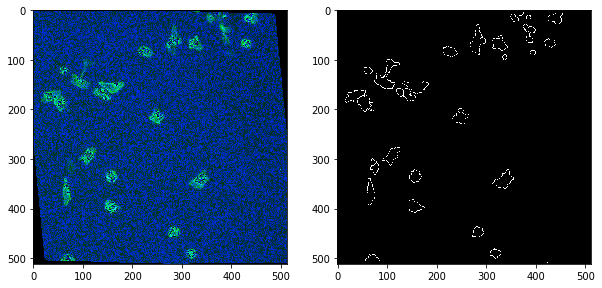

In [474]:
plt.figure(figsize = (10,10))
for X,y in train_loader:
    print(X[0].size())
    print(type(X[0]))
    plt.subplot(1,2,1)
    plt.imshow(X[0])
    plt.subplot(1,2,2)
    plt.imshow(y[0],  'gray')
    plt.show()
    break